In [1]:
import librariesImport
import gedlibpy
import networkx as nx
import numpy as np
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
from torch_geometric.utils import from_networkx
import functools
from tqdm import tqdm
import random
import time
import os
import torch
from multiprocessing import Pool
from matplotlib import pyplot as plt
from torch_geometric.datasets import Planetoid

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [3]:

# Filter graphs with more than max_num_nodes nodes
max_num_nodes = 20
NUM_WORKER = 16


In [25]:
# Utils

def set_x(data_obj):
    data_obj.x = torch.ones(data_obj.num_nodes, 1)
    return data_obj

def node_match(n1, n2):
    return np.argmax(n1['x']) == np.argmax(n2['x'])

# AIDS / IMDB / PROTEINS

In [231]:
DATASET = 'PROTEINS'
node_labeled = False
random.seed(0)
data_path = './data/'+ DATASET + '/'
if not os.path.isdir(data_path):
    os.mkdir(data_path)

# Load dataset
data = TUDataset('./',DATASET)

# Uncomment the following line when generating graph with no node label
# Filter graphs with more than max_num_nodes nodes
data = list(filter(lambda x: x.num_nodes <= max_num_nodes, data))
print(f"Graphs with at most {max_num_nodes} nodes: {len(data)}")

new_data = data
if not node_labeled:
    new_data = list(map(set_x, data))
graphs = list(map(functools.partial(to_networkx, to_undirected=True, node_attrs = ['x']), new_data))
print("Total number of graphs in the dataset: ", len(graphs))



In [207]:
graphs[0].nodes[0]

{'x': [1.0]}

In [208]:
data[0].x.argmax(dim = -1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [211]:

# Filter Isomorphic graphs using nx.is_isomorphic
non_iso_graphs = [graphs[0]]

if node_labeled:
    node_match_fun = node_match
else:
    node_match_fun = None

print("Filtering isomorphic graphs...")
for i in tqdm(range(1, len(graphs))):
    for j in range(len(non_iso_graphs)):
        if nx.is_isomorphic(graphs[i], graphs[j], node_match=node_match_fun):
            #print("Graph ", i, " is isomorphic to graph ", j)
            break
    else:
        #print("Including graph ", i, " in non_iso_graphs")
        non_iso_graphs.append(graphs[i])
print(f"Total number of non-isomorphic graphs: {len(non_iso_graphs)}")

Filtering isomorphic graphs...


100%|██████████| 411/411 [00:00<00:00, 1204.23it/s]

Total number of non-isomorphic graphs: 304


In [214]:
size = list(map(lambda x: x.number_of_nodes(), non_iso_graphs))
max_size = max(size)
print(f"Maximum number of nodes in the dataset: {max_size}")

Maximum number of nodes in the dataset: 20


In [212]:
random.shuffle(non_iso_graphs)    # Shuffle the list of graphs
train_size = int(0.6*len(non_iso_graphs))
val_size = int(0.2*len(non_iso_graphs))
test_size = len(non_iso_graphs) - train_size - val_size

train_graphs = non_iso_graphs[:train_size]
val_graphs = non_iso_graphs[train_size:train_size+val_size]
test_graphs = non_iso_graphs[train_size+val_size:]
print(f"Train: {len(train_graphs)}, Val: {len(val_graphs)}, Test: {len(test_graphs)}")


# Dump Non-isomorphic Graphs 
train_data = []
for graph in train_graphs:
    data = from_networkx(graph)
    train_data.append(data)
torch.save(train_data, data_path + "train.pt")
print(f"saved {DATASET} into {data_path}train.pt")

val_data = []
for graph in val_graphs:
    data = from_networkx(graph)
    val_data.append(data)
torch.save(val_data, data_path + "val.pt")
print(f"saved {DATASET} into {data_path}val.pt")

test_data = []
for graph in test_graphs:
    data = from_networkx(graph)
    test_data.append(data)
torch.save(test_data, data_path + "test.pt")
print(f"saved {DATASET} into {data_path}test.pt")



Train: 182, Val: 60, Test: 62
saved PROTEINS into ./data/PROTEINS/train.pt
saved PROTEINS into ./data/PROTEINS/val.pt
saved PROTEINS into ./data/PROTEINS/test.pt


In [37]:
train_data = torch.load(data_path + "train.pt")
len(train_data)

223

In [39]:
dummy = [train_data[:3]]
torch.save(dummy, "dummy.pt")

In [52]:
sample = list(filter(lambda x: x.num_nodes <= 20, train_data))
len(sample)

223

In [51]:
torch.save(sample[:3], "dummy2.pt")

(array([30., 30., 27., 33.,  0., 20., 22., 22., 25., 14.]),
 array([12. , 12.8, 13.6, 14.4, 15.2, 16. , 16.8, 17.6, 18.4, 19.2, 20. ]),
 <BarContainer object of 10 artists>)

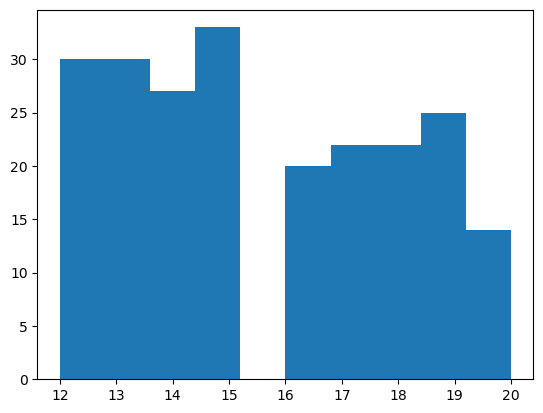

In [58]:
sizes = list(map(lambda x: x.num_nodes, train_data))
plt.hist(sizes)

(array([12., 10.,  9.,  9.,  0.,  8.,  6.,  9.,  7.,  4.]),
 array([12. , 12.8, 13.6, 14.4, 15.2, 16. , 16.8, 17.6, 18.4, 19.2, 20. ]),
 <BarContainer object of 10 artists>)

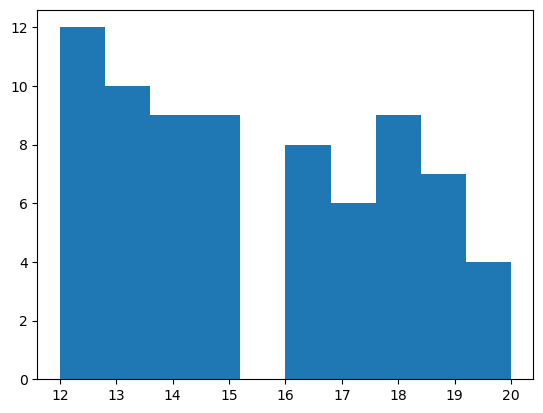

In [61]:
sizes = list(map(lambda x: x.num_nodes, val_data))
plt.hist(sizes)

(array([ 4., 13.,  6., 13.,  0.,  9.,  5., 10., 10.,  5.]),
 array([12. , 12.8, 13.6, 14.4, 15.2, 16. , 16.8, 17.6, 18.4, 19.2, 20. ]),
 <BarContainer object of 10 artists>)

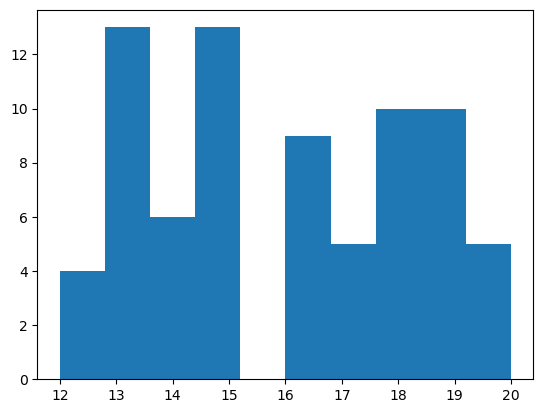

In [62]:
sizes = list(map(lambda x: x.num_nodes, test_data))
plt.hist(sizes)

# LINUX

In [103]:
parent_folder = './LINUX/'
node_labeled = False

In [104]:
data_path = './data/LINUX/'
if not os.path.isdir(data_path):
    os.mkdir(data_path)

In [134]:
graph_list = []

data_src = os.path.join(parent_folder, 'train/')
file_list = os.listdir(data_src)
gexf_files = [file for file in file_list if file.endswith('.gexf')]

# Read the .gexf files into a list of NetworkX objects

for file in gexf_files:
    file_path = os.path.join(data_src, file)
    graph = nx.read_gexf(file_path, node_type=int)
    graph_list.append(graph)

data_src = os.path.join(parent_folder, 'test/')
file_list = os.listdir(data_src)
gexf_files = [file for file in file_list if file.endswith('.gexf')]

for file in gexf_files:
    file_path = os.path.join(data_src, file)
    graph = nx.read_gexf(file_path, node_type=int)
    graph_list.append(graph)

# Print the number of graphs read
print(f"Total number of graphs from LINUX: {len(graph_list)}")




Total number of graphs from LINUX: 1000


(array([ 11.,  71.,   0., 182.,   0., 250., 198.,   0., 125., 163.]),
 array([ 4. ,  4.6,  5.2,  5.8,  6.4,  7. ,  7.6,  8.2,  8.8,  9.4, 10. ]),
 <BarContainer object of 10 artists>)

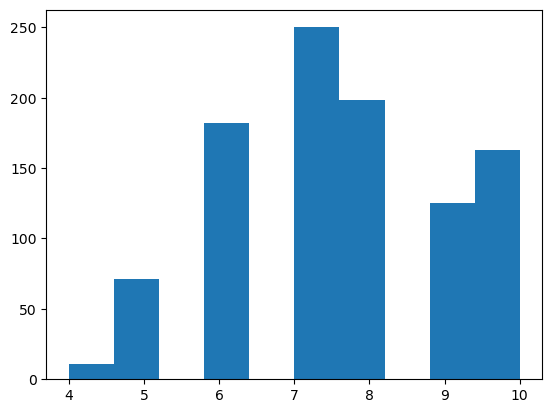

In [135]:
sizes = list(map(lambda x: x.number_of_nodes(), graph_list))
plt.hist(sizes)

In [136]:
# Filter graphs with more than max_num_nodes nodes
graphs = list(filter(lambda x: x.number_of_nodes() <= max_num_nodes, graph_list))
print(f"Graphs with at most {max_num_nodes} nodes: {len(graphs)}")

Graphs with at most 20 nodes: 1000


In [138]:

# Remove default 'label' attribute from the nodes
# Add a new attribute 'x' to the nodes

for i in tqdm(range(len(graph_list))):
    for node_detail in list(graph_list[i].nodes(data=True)):
        node_id = node_detail[0]
        del graph_list[i].nodes[node_id]['label']
        graph_list[i].nodes[node_id]['x'] = [1.0]




100%|██████████| 1000/1000 [00:00<00:00, 122225.90it/s]


In [139]:
list(graph_list[4].nodes(data=True))

[(0, {'x': [1.0]}),
 (1, {'x': [1.0]}),
 (2, {'x': [1.0]}),
 (3, {'x': [1.0]}),
 (4, {'x': [1.0]}),
 (5, {'x': [1.0]}),
 (6, {'x': [1.0]}),
 (7, {'x': [1.0]}),
 (8, {'x': [1.0]})]

In [140]:

# Filter Isomorphic graphs using nx.is_isomorphic
non_iso_graphs = [graphs[0]]

print("Filtering isomorphic graphs...")
for i in tqdm(range(1, len(graphs))):
    for j in range(len(non_iso_graphs)):
        if nx.is_isomorphic(graphs[i], graphs[j], node_match=node_match):
            #print("Graph ", i, " is isomorphic to graph ", j)
            break
    else:
        #print("Including graph ", i, " in non_iso_graphs")
        non_iso_graphs.append(graphs[i])
print(f"Total number of non-isomorphic graphs: {len(non_iso_graphs)}")

Filtering isomorphic graphs...


100%|██████████| 999/999 [00:00<00:00, 2477.09it/s]

Total number of non-isomorphic graphs: 191


In [141]:
random.shuffle(non_iso_graphs)    # Shuffle the list of graphs
train_size = int(0.6*len(non_iso_graphs))
val_size = int(0.2*len(non_iso_graphs))
test_size = len(non_iso_graphs) - train_size - val_size

train_graphs = non_iso_graphs[:train_size]
val_graphs = non_iso_graphs[train_size:train_size+val_size]
test_graphs = non_iso_graphs[train_size+val_size:]
print(f"Train: {len(train_graphs)}, Val: {len(val_graphs)}, Test: {len(test_graphs)}")


# Dump Non-isomorphic Graphs 
train_data = []
for graph in train_graphs:
    data = from_networkx(graph)
    train_data.append(data)
torch.save(train_data, data_path + "train.pt")
print(f"saved {DATASET} into {data_path}train.pt")

val_data = []
for graph in val_graphs:
    data = from_networkx(graph)
    val_data.append(data)
torch.save(val_data, data_path + "val.pt")
print(f"saved {DATASET} into {data_path}val.pt")

test_data = []
for graph in test_graphs:
    data = from_networkx(graph)
    test_data.append(data)
torch.save(test_data, data_path + "test.pt")
print(f"saved {DATASET} into {data_path}test.pt")


Train: 114, Val: 38, Test: 39
saved IMDB-BINARY into ./data/LINUX/train.pt
saved IMDB-BINARY into ./data/LINUX/val.pt
saved IMDB-BINARY into ./data/LINUX/test.pt


# OBGA

In [5]:
from ogb.graphproppred import PygGraphPropPredDataset
from torch_geometric.data import DataLoader


In [18]:
DATASET = 'ogbg-code2'
random.seed(0)
dataset = PygGraphPropPredDataset(name = DATASET) 

In [7]:
len(dataset)

452741

In [12]:
dataset[0]

Data(edge_index=[2, 243], x=[244, 2], node_is_attributed=[244, 1], node_dfs_order=[244, 1], node_depth=[244, 1], y=[1], num_nodes=244)

In [10]:
node_labeled = True

data_path = './data/'+ DATASET + '/'
if not os.path.isdir(data_path):
    os.mkdir(data_path)


In [16]:
# Comment this cell for OGBA-CODE2 and uncomment next one

# # Filter graphs with more than max_num_nodes nodes
# dataset = list(filter(lambda x: x.num_nodes <= max_num_nodes, dataset))
# print(f"Graphs with at most {max_num_nodes} nodes: {len(dataset)}")

# new_data = dataset
# if not node_labeled:
#     new_data = list(map(set_x, dataset))
    
# graphs = list(map(functools.partial(to_networkx, to_undirected=True, node_attrs = ['x']), new_data))
# print("Total number of graphs in the dataset: ", len(graphs))


KeyboardInterrupt: 

In [28]:
# For OGBA-CODE2 Label adjustment
new_graphs = []
for g in tqdm(dataset):
    if (g.num_nodes <= 20):
        labels = g.x[:, 0]
        g.x = torch.nn.functional.one_hot(labels, 97).float()
        rev1 = torch.stack((g.edge_index[1], g.edge_index[0]), 0)
        g.edge_index = torch.cat((g.edge_index, rev1), -1)
        new_graphs.append(g)

graphs = new_graphs
print("Total number valid graphs in the dataset: ", len(graphs))

100%|██████████| 452741/452741 [00:05<00:00, 86904.64it/s]

Total number valid graphs in the dataset:  404


In [32]:
graphs = list(map(functools.partial(to_networkx, to_undirected=True, node_attrs = ['x']), graphs))
print("Total number of graphs in the dataset: ", len(graphs))

AttributeError: 'Graph' object has no attribute 'node_offsets'

In [35]:
# random.shuffle(graphs)
# graphs = graphs[:10000]
# Filter Isomorphic graphs using nx.is_isomorphic
non_iso_graphs = [graphs[0]]

# def node_match(n1, n2):
#     return all(x == y for x, y in zip(n1['x'], n2['x']))
    

if node_labeled:
    node_match_fun = node_match
else:
    node_match_fun = None

print("Filtering isomorphic graphs...")
for i in tqdm(range(1, len(graphs))):
    for j in range(len(non_iso_graphs)):
        pairs = (i,j)
        if nx.is_isomorphic(graphs[i], graphs[j], node_match=node_match_fun):
            #print("Graph ", i, " is isomorphic to graph ", j)
            break
    else:
        #print("Including graph ", i, " in non_iso_graphs")
        non_iso_graphs.append(graphs[i])
print(f"Total number of non-isomorphic graphs: {len(non_iso_graphs)}")

Filtering isomorphic graphs...


 79%|███████▉  | 318/403 [09:09<02:19,  1.64s/it]

In [ ]:
sizes = list(map(lambda x: x.number_of_nodes(), non_iso_graphs))
print("Max graph size in train: ", max(sizes))

Max graph size in train:  20


In [ ]:
random.shuffle(non_iso_graphs)    # Shuffle the list of graphs
train_size = int(0.6*len(non_iso_graphs))
val_size = int(0.2*len(non_iso_graphs))
test_size = len(non_iso_graphs) - train_size - val_size

train_graphs = non_iso_graphs[:train_size]
val_graphs = non_iso_graphs[train_size:train_size+val_size]
test_graphs = non_iso_graphs[train_size+val_size:]
print(f"Train: {len(train_graphs)}, Val: {len(val_graphs)}, Test: {len(test_graphs)}")


# Dump Non-isomorphic Graphs 
train_data = []
for graph in train_graphs:
    data = from_networkx(graph)
    train_data.append(data)
torch.save(train_data, data_path + "train.pt")
print(f"saved {DATASET} into {data_path}train.pt")

val_data = []
for graph in val_graphs:
    data = from_networkx(graph)
    val_data.append(data)
torch.save(val_data, data_path + "val.pt")
print(f"saved {DATASET} into {data_path}val.pt")

test_data = []
for graph in test_graphs:
    data = from_networkx(graph)
    test_data.append(data)
# sizes = list(map(lambda x: x.num_nodes, test_data))
# print("Max graph size in train: ", max(sizes))
torch.save(test_data, data_path + "test.pt")
print(f"saved {DATASET} into {data_path}test.pt")

Train: 227, Val: 75, Test: 77
saved ogbg-code2 into ./data/ogbg-code2/train.pt
saved ogbg-code2 into ./data/ogbg-code2/val.pt
saved ogbg-code2 into ./data/ogbg-code2/test.pt


# STATS

In [218]:
data_name = 'AIDS'
train_data = torch.load(f"./data/{data_name}/" + "train.pt")
val_data = torch.load(f"./data/{data_name}/" + "val.pt")
test_data = torch.load(f"./data/{data_name}/" + "test.pt")

train_max_gsize = max([g.num_nodes for g in train_data])
val_max_gsize = max([g.num_nodes for g in val_data])
test_max_gsize = max([g.num_nodes for g in test_data])

print("Number of graphs in train, val, test: ", len(train_data), len(val_data), len(test_data))
print(f"Max graph size in train: {train_max_gsize}, val: {val_max_gsize}, test: {test_max_gsize}")
print(f"Max graph size in all data: {max(train_max_gsize, val_max_gsize, test_max_gsize)}")

Number of graphs in train, val, test:  954 318 318
Max graph size in train: 20, val: 20, test: 20
Max graph size in all data: 20


In [227]:
data_name = 'ogbg-code2'
train_data = torch.load(f"./data/{data_name}/" + "train.pt")
val_data = torch.load(f"./data/{data_name}/" + "val.pt")
test_data = torch.load(f"./data/{data_name}/" + "test.pt")

train_max_gsize = max([g.num_nodes for g in train_data])
val_max_gsize = max([g.num_nodes for g in val_data])
test_max_gsize = max([g.num_nodes for g in test_data])

print("Total number of graphs in the dataset: ", len(train_data) + len(val_data) + len(test_data))
print("Number of graphs in train, val, test: ", len(train_data), len(val_data), len(test_data))
print(f"Max graph size in train: {train_max_gsize}, val: {val_max_gsize}, test: {test_max_gsize}")
print(f"Max graph size in all data: {max(train_max_gsize, val_max_gsize, test_max_gsize)}")

Total number of graphs in the dataset:  379
Number of graphs in train, val, test:  227 75 77
Max graph size in train: 20, val: 20, test: 20
Max graph size in all data: 20
